# 115.Boston House Price Regression

### 13 개의 독립변수와 1 개의 종속변수 (주택가격 중앙값) 으로 구성

#### 독립변수 (13 개)
CRIM 자치시(town) 별 1인당 범죄율  
ZN 25,000 평방피트를 초과하는 거주지역의 비율  
INDUS 비소매상업지역이 점유하고 있는 토지의 비율  
CHAS 찰스강에 대한 더미변수(강의 경계에 위치한 경우는 1, 아니면 0)  
NOX 10ppm 당 농축 일산화질소  
RM 주택 1가구당 평균 방의 개수  
AGE 1940년 이전에 건축된 소유주택의 비율  
DIS 5개의 보스턴 직업센터까지의 접근성 지수  
RAD 방사형 도로까지의 접근성 지수  
TAX 10,000 달러 당 재산세율  
PTRATIO 자치시(town)별 학생/교사 비율  
B 1000(Bk-0.63)^2, 여기서 Bk는 자치시별 흑인의 비율을 말함  
LSTAT 모집단의 하위계층의 비율(%)   

#### 종속변수 (1 개)
MEDV 본인 소유의 주택가격(중앙값) (단위: $1,000)  

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(100)

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

Data Load

In [3]:
df_boston = pd.read_csv("boston_house.csv", index_col=0)
boston = df_boston.drop('MEDV', axis=1)
target = df_boston.pop('MEDV')

Input / Target 지정

In [4]:
X = boston.values
y = target.values
X.shape, y.shape

((506, 13), (506,))

Train/Test split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(404, 13) (102, 13) (404,) (102,)


Feature Scaling

In [6]:
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

Numpy Data를 torch tensor 로 변환

In [7]:
X_train_ts = torch.FloatTensor(X_train)
X_test_ts = torch.FloatTensor(X_test)
y_train_ts = torch.FloatTensor(y_train).view(-1, 1)
y_test_ts = torch.FloatTensor(y_test).view(-1, 1)

X_train_ts.size(), X_test_ts.size(), y_train_ts.size(), y_test_ts.size()

(torch.Size([404, 13]),
 torch.Size([102, 13]),
 torch.Size([404, 1]),
 torch.Size([102, 1]))

### Linear Model build
- hidden layer가 한개인 linear regression model 

In [8]:
class LinearReg(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearReg, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        output = self.fc3(x)
        return output

model instance 생성

In [9]:
model = LinearReg(X_train.shape[1], 1).to(device)
model

LinearReg(
  (fc1): Linear(in_features=13, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

손실함수/optimizer 정의

In [10]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Dataset Loader 생성

- torch.utils.data.TensorDataset : Dataset wrapping tensors

In [11]:
train_ds = torch.utils.data.TensorDataset(X_train_ts, y_train_ts)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)

## The training process 
- Batch data Load 
- model 을 이용하여 batch data 예측  
- loss value 계산 
- optimizer 에 저장된 grad value clear
- loss value backpropagate 
- optimizer update  

In [12]:
Loss = []
num_epochs = 100

for epoch in range(num_epochs):
    
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        yhat = model(x)
        loss = criterion(yhat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print("epoch {} loss: {:.4f}".format(epoch + 1, loss.item()))
    Loss.append(loss.item())

epoch 1 loss: 440.6200
epoch 2 loss: 694.9658
epoch 3 loss: 652.7293
epoch 4 loss: 387.0433
epoch 5 loss: 489.7896
epoch 6 loss: 432.7303
epoch 7 loss: 240.5988
epoch 8 loss: 251.2095
epoch 9 loss: 71.9873
epoch 10 loss: 153.0879
epoch 11 loss: 76.3068
epoch 12 loss: 155.3728
epoch 13 loss: 198.9258
epoch 14 loss: 86.9207
epoch 15 loss: 90.4766
epoch 16 loss: 66.0260
epoch 17 loss: 56.9644
epoch 18 loss: 32.2802
epoch 19 loss: 41.8191
epoch 20 loss: 38.4908
epoch 21 loss: 42.5038
epoch 22 loss: 59.8073
epoch 23 loss: 61.0882
epoch 24 loss: 94.4386
epoch 25 loss: 35.6982
epoch 26 loss: 93.2575
epoch 27 loss: 28.0918
epoch 28 loss: 14.3334
epoch 29 loss: 41.8580
epoch 30 loss: 28.1005
epoch 31 loss: 16.7047
epoch 32 loss: 27.8898
epoch 33 loss: 41.2378
epoch 34 loss: 19.5429
epoch 35 loss: 43.3464
epoch 36 loss: 29.0404
epoch 37 loss: 76.7764
epoch 38 loss: 69.4750
epoch 39 loss: 15.5384
epoch 40 loss: 30.6256
epoch 41 loss: 20.9034
epoch 42 loss: 39.3337
epoch 43 loss: 43.9369
epoch 44 

Test set을 이용하여 model 평가

In [13]:
print(criterion(model(X_test_ts.to(device)), y_test_ts.to(device)).item())

32.521610260009766


Loss 시각화

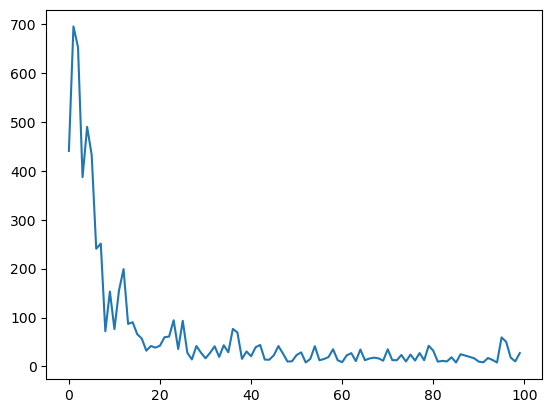

In [14]:
plt.plot(Loss)

Test set을 이용하여 예측

In [15]:
y_pred = model(X_test_ts.to(device)).cpu().detach().numpy()
y_pred.shape

(102, 1)

MSE, R2 계산

In [16]:
from sklearn.metrics import mean_squared_error, r2_score

print(mean_squared_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

32.52161155060701
0.6006111387461924


True vs. Predicted 시각화

Text(0.5, 1.0, 'Boston House Price Prediction ($1,000)')

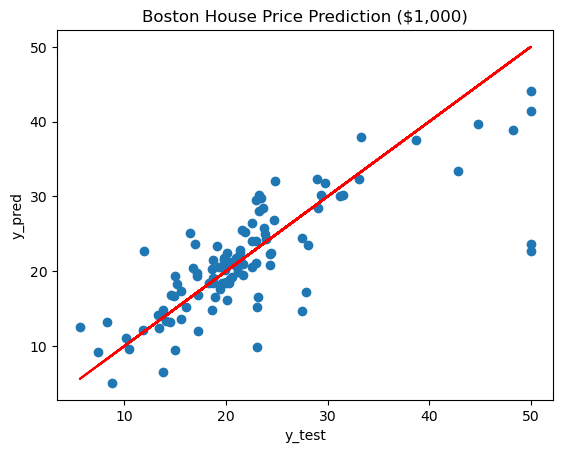

In [17]:
plt.scatter(y_test, y_pred)
plt.plot(y_test, y_test, 'r')
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.title('Boston House Price Prediction ($1,000)')

## 실습

### UCI Machine Learning Repository 의 Auto MPG dataset 을 사용하여 Regression 예측 model 작성

auto-mpg.data - data file  
auto-mpg.names - data 설명 file

1. mpg:           continuous  
2. cylinders:     multi-valued discrete  
3. displacement:  continuous (배기량)   
4. horsepower:    continuous  
5. weight:        continuous  
6. acceleration:  continuous  
7. model year:    multi-valued discrete  
8. origin:        multi-valued discrete, 1 - USA, 2 - Europe, 3 - Japan  
9. car name:      string (unique for each instance)  

Missing Attribute Values:  horsepower has 6 missing values  ==> "?" 로 들어 있으므로 read_csv 시 nan 으로 변환

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Data load 및 Preprocessing

In [20]:
from requests import get

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
file_name = "auto-mpg.data"

with open(file_name, "wb") as file:
    response = get(url)
    file.write(response.content)

In [21]:
column_names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin']

rawdata = pd.read_csv(file_name, names=column_names, na_values="?", comment="\t", sep=" ", skipinitialspace=True)
rawdata.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [22]:
rawdata.dropna(inplace=True)

data = rawdata.copy()

data = pd.get_dummies(data, columns=['cylinders', 'origin'])

label = data.pop('mpg')

In [23]:
X_train, X_test, y_train, y_test = train_test_split(data.values, label.values, random_state=0)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(294, 13) (98, 13) (294,) (98,)


In [24]:
X_train_ts = torch.FloatTensor(X_train)
X_test_ts = torch.FloatTensor(X_test)
y_train_ts = torch.FloatTensor(y_train).view(-1, 1)
y_test_ts = torch.FloatTensor(y_test).view(-1, 1)

### Regression Model Build

### train

### predict

### $r^2$ 계산